# Processamento dos dados

## Abertura dos tweets

O dataframe consiste de 200 tweets para cada candidato.

In [141]:
import pandas as pd
import glob

def df_all_folder(path,sufixo="_tweets.csv"):
    all_files = glob.glob(path + "*"+sufixo)
    li = []    
    
    for filename in all_files:
        df = pd.read_csv(filename, index_col=0)
        if "janones" not in filename: 
            li.append(df)
    names = []
    for filename in all_files:
        x = filename.replace(path, "")
        x = x.replace(sufixo, "")
        names.append(x.replace(" ","_"))
    return pd.concat(li, axis=0, keys =names).reset_index().rename(columns={'level_0': "candidato"})

In [142]:
df = df_all_folder("dados/ultimos_100_tweets/")
df

,candidato,level_1,text,id,retweets,replys,likes,author_id,source,lang,created_at,place_id
0,dados/ultimos_100_tweets\bivar,0,@fartosuely1 @_afadamadrinha @thinkmoreBrazil ...,1.537649e+18,1.0,0.0,1.0,1.410976e+18,Twitter for Android,pt,2022-06-17 04:11:17+00:00,NaN
1,dados/ultimos_100_tweets\bivar,1,@ElenTorres10 Quem confia no Bivar?,1.537646e+18,0.0,0.0,0.0,2.387485e+08,Twitter for iPhone,pt,2022-06-17 04:00:30+00:00,NaN
2,dados/ultimos_100_tweets\bivar,2,"Moro pode escolher cargo para concorrer, diz o...",1.537646e+18,0.0,0.0,0.0,1.487306e+18,Twitter Web App,pt,2022-06-17 03:58:56+00:00,NaN
3,dados/ultimos_100_tweets\bivar,3,"@luzia74992679 Acorda Bivar, é Moro para Presi...",1.537646e+18,0.0,0.0,0.0,1.410976e+18,Twitter for Android,pt,2022-06-17 03:58:30+00:00,NaN
4,dados/ultimos_100_tweets\bivar,4,"Bivar pensa que todos são alienados, Moro para...",1.537645e+18,1.0,1.0,2.0,1.487306e+18,Twitter Web App,pt,2022-06-17 03:54:36+00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1831,dados/ultimos_100_tweets\sofia_manzano,95,@Anitta ANITTA VC PRECISA VER SOBRE A VERA LÚC...,1.546963e+18,0.0,0.0,0.0,1.460646e+18,Twitter for Android,pt,2022-07-12 21:02:57+00:00,NaN
1832,dados/ultimos_100_tweets\sofia_manzano,96,Olá 👋 passando aqui para informar que a partir...,1.546962e+18,0.0,0.0,4.0,4.195617e+08,Twitter Web App,pt,2022-07-12 20:57:43+00:00,NaN
1833,dados/ultimos_100_tweets\sofia_manzano,97,O dinheiro que a mona investiu pra superar a V...,1.546958e+18,0.0,1.0,1.0,1.158390e+18,Twitter for iPhone,pt,2022-07-12 20:40:36+00:00,NaN
1834,dados/ultimos_100_tweets\sofia_manzano,98,"Daqui a pouco, as 18h, a rádio web 2 de Julho ...",1.546957e+18,0.0,0.0,0.0,1.506264e+18,Twitter Web App,pt,2022-07-12 20:35:52+00:00,NaN


## Retirando stopwords

In [143]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eduar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [144]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eduar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [145]:
df = df[df['text'].notna()]

In [146]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
 
def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('portuguese'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)
     
x = df.apply(lambda row: remove_stop_words(row['text']), axis=1)
x


0       thinkmorebrazil deltanmd acorda bivar moro pre...
1                                            confia bivar
2       moro pode escolher cargo concorrer diz preside...
3                            acorda bivar moro presidente
4       bivar pensa todos alienados moro governador pr...
                              ...                        
1831    anitta anitta vc precisa ver sobre vera lúcia ...
1832    olá passando aqui informar partir semana pré p...
1833    dinheiro mona investiu pra superar vera lúcia ...
1834    daqui pouco rádio web julho reapresenta entrev...
1835    simonetebetbr tebet polarização pt x psdb bols...
Length: 1738, dtype: object

## Leitura dos labels

Leitura dos labels categorizados manualmente. Cada tweet foi categorizado com NT = neutro, PS = positivo e NG = negativo. Após a leitura do data_set os labels foram transformados em numeros. Zero representando os tweets negativos, um os tweets neutros e dois os tweets positivos.

In [92]:
y = df_all_folder("dados/ultimos_100_tweets/",sufixo='_labeled.csv')['level_1'].dropna().apply(lambda x : x.upper())
y

0       NT
1       NG
2       NG
3       NG
4       NG
        ..
1734    PS
1735    NT
1736    NT
1737    NT
1738    NT
Name: level_1, Length: 1738, dtype: object

In [93]:
y = y.apply(lambda x: 0 if x == 'NG' else 1 if x == 'NT' else 2)
y

0       1
1       0
2       0
3       0
4       0
       ..
1734    2
1735    1
1736    1
1737    1
1738    1
Name: level_1, Length: 1738, dtype: int64

## Tokenização das palavras
Após esses processamentos, foi tokenizado cada palavra dentro do texto.

In [148]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

def tokenizar(x):
    max_words = 100000
    
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(x)
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=500)
x = tokenizar(x)

## Separação de teste e treino

Tanto os labels quanto os textos foram separados em diferentes conjuntos. Um de treino e outro de teste. O de treino possui 70% dos dados e o de teste possui 30%.

In [95]:
y_test = y[0:int(len(y)*0.3)]
y_trein = y[int(len(y)*0.3):len(y)]
x_test = x[0:int(len(x)*0.3)]
x_trein = x[int(len(x)*0.3):len(x)]

# Criação de modelos
## Criação do primeiro modelo

O primeiro modelo para a tentativa de categorização de um tweet entre neutro, positivo e negativo foi uma rede neural composta de 5 camadas LSTM e 3 camadas densas. Os três neurônios de saída representam cada um humor de acordo com os numeros representados anteriormente.

In [96]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Masking, Conv1D, MaxPool1D, GRU
from keras.layers import Embedding
from keras.metrics import Precision, Recall
 
model = Sequential() 
model.add(Embedding(100000, 32, input_length=500)) 
model.add(Masking(mask_value=0.0))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [97]:
model.fit(x_trein, y_trein, epochs=20, verbose=1)

Epoch 1/20
39/39 [==============================] - 33s 158ms/step - loss: 0.9938 - accuracy: 0.5785
Epoch 2/20
39/39 [==============================] - 6s 161ms/step - loss: 0.9652 - accuracy: 0.5809
Epoch 3/20
39/39 [==============================] - 6s 161ms/step - loss: 0.9246 - accuracy: 0.5916
Epoch 4/20
39/39 [==============================] - 6s 159ms/step - loss: 0.7338 - accuracy: 0.7017
Epoch 5/20
39/39 [==============================] - 6s 162ms/step - loss: 0.6535 - accuracy: 0.7453
Epoch 6/20
39/39 [==============================] - 6s 161ms/step - loss: 0.4962 - accuracy: 0.7872
Epoch 7/20
39/39 [==============================] - 7s 168ms/step - loss: 0.4545 - accuracy: 0.8053
Epoch 8/20
39/39 [==============================] - 7s 173ms/step - loss: 0.4303 - accuracy: 0.8077
Epoch 9/20
39/39 [==============================] - 7s 183ms/step - loss: 0.3811 - accuracy: 0.8406
Epoch 10/20
39/39 [==============================] - 8s 198ms/step - loss: 0.3558 - accuracy: 0.871

In [98]:
import numpy as np
model.evaluate(np.array(x_test),np.array(y_test))

17/17 [==============================] - 10s 65ms/step - loss: 2.3278 - accuracy: 0.4299


[2.327836036682129, 0.42994242906570435]

## Criação do segundo e terceiro modelo

Com o fracasso do modelo anterior, foi usado duas redes neurais que classificam somente para positivo ou somente para negativo, para fazer a rede aprender mais facilmente valores opostos. A segunda rede é identica a primeira tirando que o ultimo layer possui apenas um neurônio. Quanto maior ele aumenta a probabilidade de ser positivo(para a segunda) ou negativo(para a terceira).

In [121]:
new_y = y.copy()
new_y = new_y.apply(lambda x: 1 if x == 2 else 0)
new_y

0       0
1       0
2       0
3       0
4       0
       ..
1734    1
1735    0
1736    0
1737    0
1738    0
Name: level_1, Length: 1738, dtype: int64

In [122]:
y_test_n = new_y[0:int(len(new_y)*0.3)]
y_trein_n = new_y[int(len(new_y)*0.3):len(new_y)]

In [123]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Masking, Conv1D, MaxPool1D, GRU
from keras.layers import Embedding
from keras.metrics import Precision, Recall
 
modelp = Sequential() 
modelp.add(Embedding(100000, 32, input_length=500)) 
modelp.add(Masking(mask_value=0.0))
modelp.add(LSTM(32, return_sequences=True))
modelp.add(LSTM(32, return_sequences=True))
modelp.add(LSTM(32, return_sequences=True))
modelp.add(LSTM(32, return_sequences=True))
modelp.add(LSTM(32, return_sequences=False))
modelp.add(Dense(64, activation='relu'))
modelp.add(Dense(64, activation='relu'))
modelp.add(Dense(1))
modelp.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [124]:
modelp.fit(x_trein, y_trein_n, epochs=12, verbose=1)

Epoch 1/12
39/39 [==============================] - 38s 201ms/step - loss: 0.6117 - accuracy: 0.7354
Epoch 2/12
39/39 [==============================] - 8s 210ms/step - loss: 0.5810 - accuracy: 0.7354
Epoch 3/12
39/39 [==============================] - 7s 184ms/step - loss: 0.5239 - accuracy: 0.7494
Epoch 4/12
39/39 [==============================] - 8s 217ms/step - loss: 0.3916 - accuracy: 0.8422
Epoch 5/12
39/39 [==============================] - 9s 231ms/step - loss: 0.2445 - accuracy: 0.9088
Epoch 6/12
39/39 [==============================] - 10s 250ms/step - loss: 0.1882 - accuracy: 0.9384
Epoch 7/12
39/39 [==============================] - 7s 191ms/step - loss: 0.1492 - accuracy: 0.9491
Epoch 8/12
39/39 [==============================] - 7s 168ms/step - loss: 0.1304 - accuracy: 0.9589
Epoch 9/12
39/39 [==============================] - 8s 209ms/step - loss: 0.1140 - accuracy: 0.9638
Epoch 10/12
39/39 [==============================] - 8s 204ms/step - loss: 0.1155 - accuracy: 0.96

In [125]:
modelp.evaluate(np.array(x_test),np.array(y_test_n))

17/17 [==============================] - 10s 69ms/step - loss: 0.9328 - accuracy: 0.7198


[0.9327571392059326, 0.7197696566581726]

In [126]:
previsao1 = modelp.predict(np.array(x_test))

17/17 [==============================] - 9s 74ms/step


In [127]:
def convert(num):
    if num <=0.5:
        return 0
    else:
        return 1

arr_previsao = previsao1
arr_real = y_test_n
converter = np.vectorize(convert)
arr_previsao = converter(arr_previsao)

In [128]:
def classificador(previsao, real):
    VP, VN, FN, FP = 0, 0, 0, 0
    for i in range(len(real)):
        if real[i] == 1 and previsao[i] == 1:
            VP+=1
        elif real[i] == 0 and previsao[i] == 0:
            VN+=1
        elif real[i] == 1 and previsao[i] == 0:
            FN+=1
        else:
            FP+=1
    return VP, VN, FN, FP

In [129]:

VP, VN, FN, FP = classificador(arr_previsao, arr_real)

In [130]:
print(VP, VN, FN, FP)

24 351 62 84


In [131]:
acuracia = (VP+VN)/(VP+VN+FP+FN)
recall = VP / (VP + FN)
precisao = VP / (VP + FP)
f1_score = 2 * (precisao * recall) / (precisao + recall)

print("Acuracia: {:.2f} \nRevocação: {:.2f} \nPrecisão: {:.2f} \nf1-Score: {:.2f}".format(acuracia,recall,precisao,f1_score))

Acuracia: 0.72 
Revocação: 0.28 
Precisão: 0.22 
f1-Score: 0.25


In [110]:
new_y2 = y.copy()
new_y2 = new_y2.apply(lambda x: 1 if x == 0 else 0)
new_y2

0       0
1       1
2       1
3       1
4       1
       ..
1734    0
1735    0
1736    0
1737    0
1738    0
Name: level_1, Length: 1738, dtype: int64

In [111]:
y_test_n2 = new_y2[0:int(len(new_y2)*0.3)]
y_trein_n2 = new_y2[int(len(new_y2)*0.3):len(new_y2)]

In [112]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Masking, Conv1D, MaxPool1D, GRU
from keras.layers import Embedding
from keras.metrics import Precision, Recall
 
modeln = Sequential() 
modeln.add(Embedding(100000, 32, input_length=500)) 
modeln.add(Masking(mask_value=0.0))
modeln.add(LSTM(32, return_sequences=True))
modeln.add(LSTM(32, return_sequences=True))
modeln.add(LSTM(32, return_sequences=True))
modeln.add(LSTM(32, return_sequences=True))
modeln.add(LSTM(32, return_sequences=False))
modeln.add(Dense(64, activation='relu'))
modeln.add(Dense(64, activation='relu'))
modeln.add(Dense(1))
modeln.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [113]:
modeln.fit(x_trein, y_trein_n2, epochs=12, verbose=1)

Epoch 1/12
39/39 [==============================] - 34s 176ms/step - loss: 0.4987 - accuracy: 0.8455
Epoch 2/12
39/39 [==============================] - 7s 166ms/step - loss: 0.4353 - accuracy: 0.8455
Epoch 3/12
39/39 [==============================] - 7s 188ms/step - loss: 0.4316 - accuracy: 0.8455
Epoch 4/12
39/39 [==============================] - 7s 170ms/step - loss: 0.4420 - accuracy: 0.8455
Epoch 5/12
39/39 [==============================] - 7s 182ms/step - loss: 0.4327 - accuracy: 0.8455
Epoch 6/12
39/39 [==============================] - 7s 185ms/step - loss: 0.4392 - accuracy: 0.8455
Epoch 7/12
39/39 [==============================] - 8s 196ms/step - loss: 0.4341 - accuracy: 0.8455
Epoch 8/12
39/39 [==============================] - 8s 204ms/step - loss: 0.4329 - accuracy: 0.8455
Epoch 9/12
39/39 [==============================] - 9s 223ms/step - loss: 0.4306 - accuracy: 0.8455
Epoch 10/12
39/39 [==============================] - 8s 207ms/step - loss: 0.4342 - accuracy: 0.845

In [114]:
modeln.evaluate(np.array(x_test),np.array(y_test_n2))

17/17 [==============================] - 11s 79ms/step - loss: 0.7776 - accuracy: 0.6296


[0.7776023745536804, 0.6295585632324219]

In [117]:
previsao2 = modeln.predict(np.array(x_test))

17/17 [==============================] - 16s 67ms/step


In [118]:
def convert(num):
    if num <=0.5:
        return 0
    else:
        return 1

arr_previsao = previsao2
arr_real = y_test_n
converter = np.vectorize(convert)
arr_previsao = converter(arr_previsao)

In [119]:
VP, VN, FN, FP = classificador(arr_previsao, arr_real)
print(VP, VN, FN, FP)

0 435 86 0


# Previsões da rede

## Candidato por opinião positiva

In [149]:
df['sentimentos'] = modelp.predict(np.array(x))

55/55 [==============================] - 3s 57ms/step


C:\Users\eduar\AppData\Local\Temp\ipykernel_10768\1129059046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentimentos'] = model.predict(np.array(x))


In [150]:
df['sentimento'] = df['sentimentos'].apply(lambda x: 'Positivo' if x > 0.5 else 'Negativo ou neutro')

C:\Users\eduar\AppData\Local\Temp\ipykernel_10768\4284445533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentimento'] = df['sentimentos'].apply(lambda x: 'Positivo' if x > 0.5 else 'Negativo ou neutro')


In [152]:
df['candidato'] = df['candidato'].apply(lambda x: x.replace("dados/ultimos_100_tweets\\",''))

C:\Users\eduar\AppData\Local\Temp\ipykernel_10768\828491994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['candidato'] = df['candidato'].apply(lambda x: x.replace("dados/ultimos_100_tweets\\",''))


In [153]:
df

,candidato,level_1,text,id,retweets,replys,likes,author_id,source,lang,created_at,place_id,sentimentos,sentimento
0,bivar,0,@fartosuely1 @_afadamadrinha @thinkmoreBrazil ...,1.537649e+18,1.0,0.0,1.0,1.410976e+18,Twitter for Android,pt,2022-06-17 04:11:17+00:00,NaN,-5.707729,Negativo ou neutro
1,bivar,1,@ElenTorres10 Quem confia no Bivar?,1.537646e+18,0.0,0.0,0.0,2.387485e+08,Twitter for iPhone,pt,2022-06-17 04:00:30+00:00,NaN,-1.141681,Negativo ou neutro
2,bivar,2,"Moro pode escolher cargo para concorrer, diz o...",1.537646e+18,0.0,0.0,0.0,1.487306e+18,Twitter Web App,pt,2022-06-17 03:58:56+00:00,NaN,3.122572,Positivo
3,bivar,3,"@luzia74992679 Acorda Bivar, é Moro para Presi...",1.537646e+18,0.0,0.0,0.0,1.410976e+18,Twitter for Android,pt,2022-06-17 03:58:30+00:00,NaN,-2.410756,Negativo ou neutro
4,bivar,4,"Bivar pensa que todos são alienados, Moro para...",1.537645e+18,1.0,1.0,2.0,1.487306e+18,Twitter Web App,pt,2022-06-17 03:54:36+00:00,NaN,-3.915273,Negativo ou neutro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1831,sofia_manzano,95,@Anitta ANITTA VC PRECISA VER SOBRE A VERA LÚC...,1.546963e+18,0.0,0.0,0.0,1.460646e+18,Twitter for Android,pt,2022-07-12 21:02:57+00:00,NaN,2.907660,Positivo
1832,sofia_manzano,96,Olá 👋 passando aqui para informar que a partir...,1.546962e+18,0.0,0.0,4.0,4.195617e+08,Twitter Web App,pt,2022-07-12 20:57:43+00:00,NaN,-7.895892,Negativo ou neutro
1833,sofia_manzano,97,O dinheiro que a mona investiu pra superar a V...,1.546958e+18,0.0,1.0,1.0,1.158390e+18,Twitter for iPhone,pt,2022-07-12 20:40:36+00:00,NaN,-6.716144,Negativo ou neutro
1834,sofia_manzano,98,"Daqui a pouco, as 18h, a rádio web 2 de Julho ...",1.546957e+18,0.0,0.0,0.0,1.506264e+18,Twitter Web App,pt,2022-07-12 20:35:52+00:00,NaN,-7.037282,Negativo ou neutro


In [157]:
df = df.drop(df[df['sentimento'] == 'Negativo ou neutro'].index).groupby(by='candidato').count()

In [163]:
df = df.reset_index()

In [167]:
df = df.sort_values(by='sentimento')

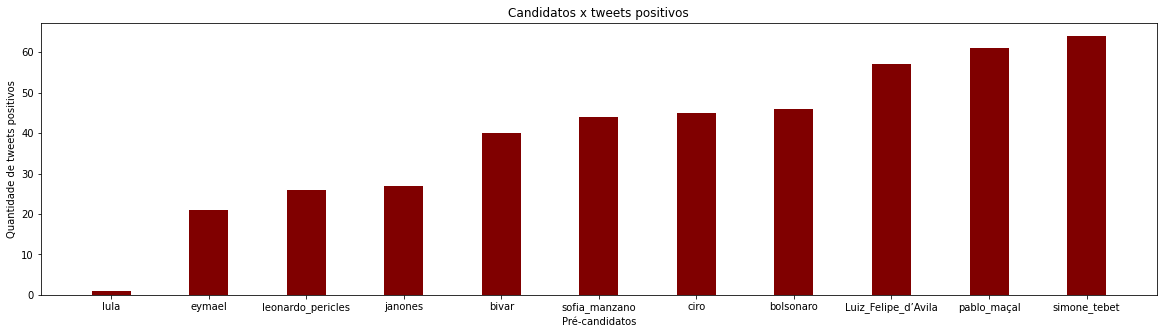

In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 5))

plt.bar(df['candidato'].replace('_',' '), df['sentimento'], color ='maroon',
        width = 0.4)
        
plt.xlabel("Pré-candidatos")
plt.ylabel("Quantidade de tweets positivos")
plt.title("Candidatos x tweets positivos")
plt.show()